In [40]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity as mat_cosine_similarity
from sklearn.preprocessing import normalize

# Functions

In [84]:
##########################################################################################################
############## General Bag of Words Model functions ######################################################
##########################################################################################################

# Takes in two course names, the name of the column that holds the names, the dataframe, and the similarity matrix
# and returns their cosine similarity
def get_similarity(name1, name2, col_name, df, matrix):
    idx_1 = df[df[col_name] == name1].index
    idx_1 = idx_1[0]
    idx_2 = df[df[col_name] == name2].index
    idx_2 = idx_2[0]
    return matrix[idx_1, idx_2]

# Gets the course's cleaned description that is used to vectorize it
def get_clean_desc(df, course_name):
    idx_1 = df[df['department'] == course_name].index
    idx_1 = idx_1[0]
    return df.iloc[idx_1]['cleaned_description']

# Gets the course's regular description that is used to vectorize it
def get_reg_desc(df, course_name):
    idx_1 = df[df['course'] == course_name].index
    idx_1 = idx_1[0]
    return df.iloc[idx_1]['description_x']



#####################################################################################################
################ General Similarty Data and Visualization Tools #####################################
#####################################################################################################

# Return the n most common words shared between two strings.
def common_words(str1, str2, n):
    # Splitting the strings into words
    words_str1 = str1.split()
    words_str2 = str2.split()

    # Creating a dictionary to count the occurrences of each word in both strings
    word_count = {}
    for word in words_str1:
        if word in words_str2:
            word_count[word] = min(words_str1.count(word), words_str2.count(word))

    # Sorting the dictionary by the frequency of the words
    sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    return sorted_word_count[0:n]


# Return the n most similar departments
def get_related(name, df, deps,  matrix, n):
    n=n+1
    idx = df[df['department'] == name].index
    sims = matrix[idx]
    # Get indices of sorted elements
    sorted_indices = np.argsort(sims)
    # Get indices of top n largest elements
    top_n_indices = sorted_indices[0][-n:][::-1]
    top_n_deps = np.array(deps)[top_n_indices]
    top_n_deps = np.delete(top_n_deps, np.where(top_n_deps == name))
    return top_n_deps

def get_threshold(matrix, max_pairs):
    """
    Find the threshold for similarity scores in the matrix.

    :param matrix: A 2D numpy array containing similarity scores between classes.
    :param max_pairs: Maximum number of class pairs with similarity above the threshold.
    :return: Threshold value.
    """

    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Input must be a square matrix")

    # Get the upper triangle of the matrix, excluding the diagonal
    upper_triangle = np.triu(matrix, k=1)
    
    # Flatten and sort
    flat_upper = upper_triangle.flatten()
    sorted_similarities = np.sort(flat_upper[flat_upper != 0])[::-1]
    
    # Check if n is valid
    if max_pairs <= 0 or max_pairs > len(sorted_similarities):
        raise ValueError("max_pairs must be between 1 and the number of upper triangle elements")
    
    # Get the nth highest value
    threshold = sorted_similarities[max_pairs-1]

    return threshold

# Generating dataframe of related departments
def dep_sim_analysis(df, matrix, dep_name):
    related_departments = get_related('ENVIRON', df, matrix, 10)
    word_df = pd.DataFrame()
    for dept in related_departments:
        word_df[dept] = common_words(get_clean_desc(df, dep_name), get_clean_desc(df, dept), 10)
    return word_df

# Loading embeddings dataset

In [86]:
import ast
# Load data
df = pd.read_pickle('embeddings.pkl')

# Groupby department

In [88]:
# Get the department of each course
df['department'] = df['course'].str.extract(r'([A-Z]+)')
# Groupby Operation
df = df.groupby('department')['embedding'].apply(np.sum).reset_index()

In [89]:
df['embedding'] = df['embedding'].apply(lambda x: normalize([x])[0])

## Example of generating networks

In [91]:
# Make similarity matrix
matrix = [vec for vec in df['embedding']]
# Compute cosine similarities
similarity_matrix = mat_cosine_similarity(matrix)
#Find similar courses
deps = df['department'].tolist()

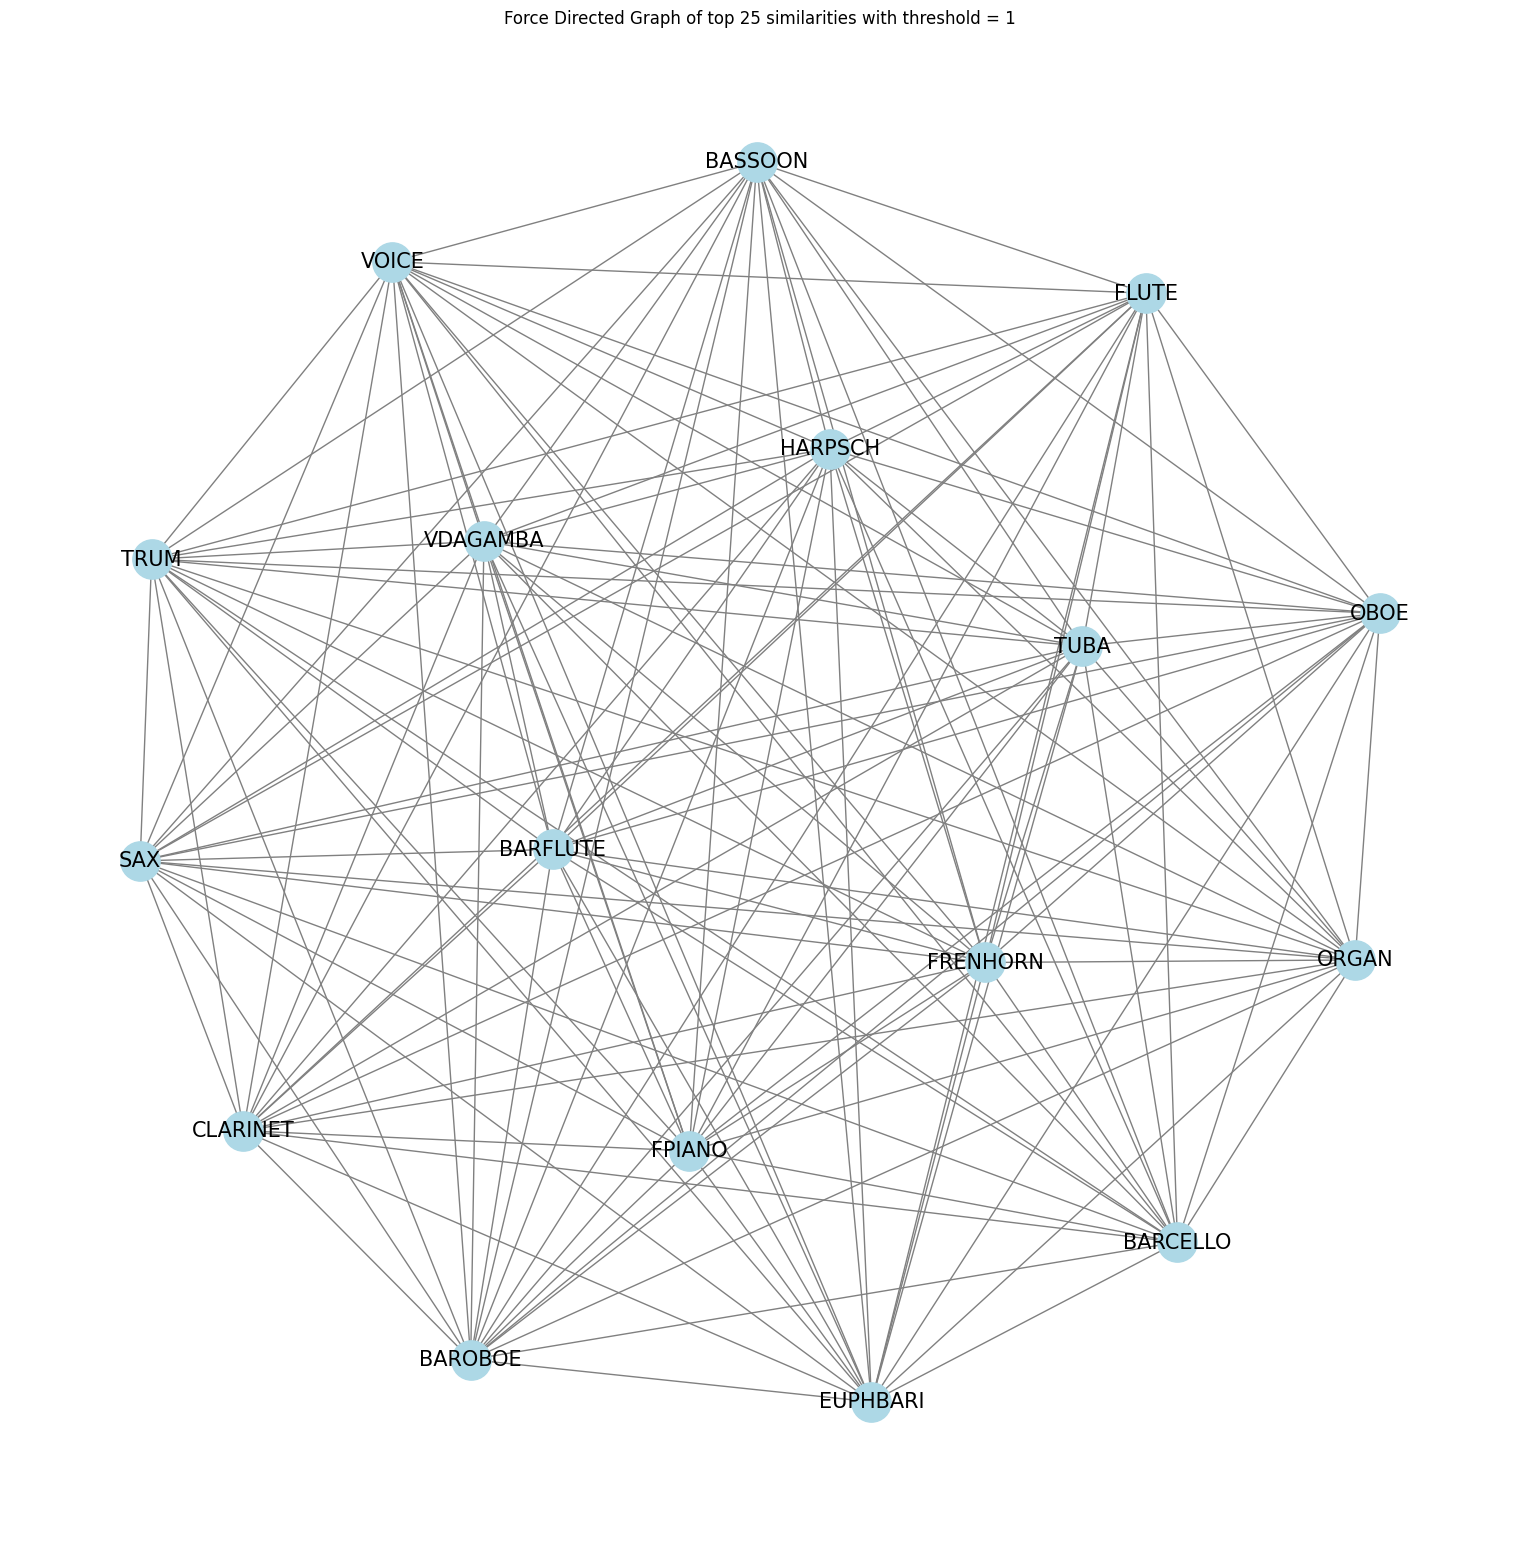

In [46]:
adjacency_matrix = similarity_matrix

# Create a graph
G = nx.Graph()

threshold = get_threshold(similarity_matrix, 25)

course_indices = set()
# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        if similarity_matrix[i][j] > threshold:
            course_indices.add(i)
            course_indices.add(j)
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title(f"Force Directed Graph of top 25 similarities with threshold = {threshold}")
plt.show()

In [48]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Statistics of similarity distribution

In [49]:
np.fill_diagonal(similarity_matrix, np.nan)
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
similarities = similarity_matrix[upper_tri_indices]

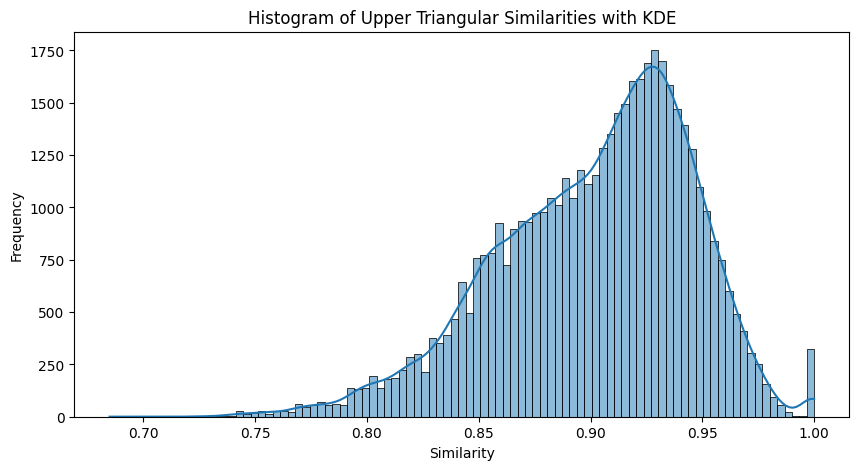

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=True)
plt.title('Histogram of Upper Triangular Similarities with KDE')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

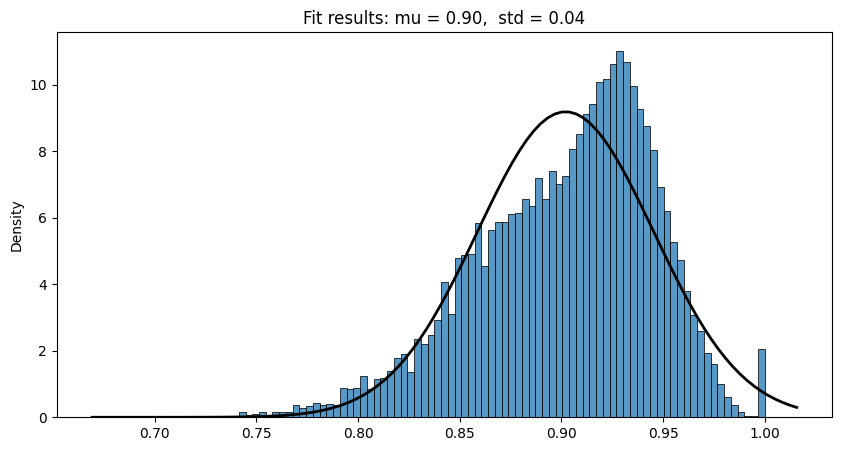

In [51]:
from scipy.stats import norm

# Fit a normal distribution
mu, std = norm.fit(similarities)

# Plot the histogram and fitted pdf
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=False, stat="density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()


## Finding pairs with similarity 1

In [92]:
ones = np.where(np.triu(np.isclose(similarity_matrix, 1.0), k=1))
idxs = list(zip(ones[0], ones[1]))
for pair in idxs:
    print(f'{deps[pair[0]]} and {deps[pair[1]]}')

BARCELLO and BARFLUTE
BARCELLO and BAROBOE
BARCELLO and BASSOON
BARCELLO and CLARINET
BARCELLO and EUPHBARI
BARCELLO and FLUTE
BARCELLO and FPIANO
BARCELLO and FRENHORN
BARCELLO and HARPSCH
BARCELLO and OBOE
BARCELLO and ORGAN
BARCELLO and SAX
BARCELLO and TROMBONE
BARCELLO and TRUM
BARCELLO and TUBA
BARCELLO and VDAGAMBA
BARCELLO and VOICE
BARFLUTE and BAROBOE
BARFLUTE and BASSOON
BARFLUTE and CLARINET
BARFLUTE and EUPHBARI
BARFLUTE and FLUTE
BARFLUTE and FPIANO
BARFLUTE and FRENHORN
BARFLUTE and HARPSCH
BARFLUTE and OBOE
BARFLUTE and ORGAN
BARFLUTE and SAX
BARFLUTE and TROMBONE
BARFLUTE and TRUM
BARFLUTE and TUBA
BARFLUTE and VDAGAMBA
BARFLUTE and VOICE
BAROBOE and BASSOON
BAROBOE and CLARINET
BAROBOE and EUPHBARI
BAROBOE and FLUTE
BAROBOE and FPIANO
BAROBOE and FRENHORN
BAROBOE and HARPSCH
BAROBOE and OBOE
BAROBOE and ORGAN
BAROBOE and SAX
BAROBOE and TROMBONE
BAROBOE and TRUM
BAROBOE and TUBA
BAROBOE and VDAGAMBA
BAROBOE and VOICE
BASSOON and CLARINET
BASSOON and EUPHBARI
BASSOON a

In [93]:
# Remove overlapping departments
bad_deps = set()
for pair in idxs:
    bad_deps.add(deps[pair[0]])
    bad_deps.add(deps[pair[1]])
df = df[~df['department'].isin(bad_deps)]

In [94]:
df

,department,embedding
0,AAS,"[-0.007471468722095482, -0.015007437591309193,..."
1,ACC,"[-0.006716650609556021, -0.013041202318509464,..."
2,ADABRD,"[3.636273081997788e-05, -0.0033828538740718083..."
3,AERO,"[-0.005027363162603976, -0.012076861185646177,..."
4,AEROSP,"[-0.0039825493987399735, 7.653774690759282e-05..."
...,...,...
305,WGS,"[-0.014064112656916943, -0.010529331787006794,..."
306,WMBA,"[-0.009108205995515877, -0.014643514844982105,..."
307,WOMENSTD,"[-0.009101409058745659, -0.014184146481319285,..."
308,WRITING,"[-0.004427961877581703, 0.007824535475361959, ..."


# Renormalizing similarities

In [56]:
from scipy import stats
# Expects np array
def renormalize_similarities(similarity_matrix):
    # Calculate z-scores
    z_scores = stats.zscore(similarity_matrix, axis=None)
    
    # Shift z-scores to make the minimum 0
    z_scores_shifted = z_scores - z_scores.min()
    
    # Rescale to [0, 1] range
    renormalized = z_scores_shifted / z_scores_shifted.max()
    
    return renormalized

In [85]:
df

,department,embedding
0,AAS,"[-0.007471468722095482, -0.015007437591309193,..."
1,ACC,"[-0.006716650609556021, -0.013041202318509464,..."
2,ADABRD,"[3.636273081997788e-05, -0.0033828538740718083..."
3,AERO,"[-0.005027363162603976, -0.012076861185646177,..."
4,AEROSP,"[-0.0039825493987399735, 7.653774690759282e-05..."
...,...,...
305,WGS,"[-0.014064112656916943, -0.010529331787006794,..."
306,WMBA,"[-0.009108205995515877, -0.014643514844982105,..."
307,WOMENSTD,"[-0.009101409058745659, -0.014184146481319285,..."
308,WRITING,"[-0.004427961877581703, 0.007824535475361959, ..."


In [65]:
# Make similarity matrix (this is the df with bad deps removed)
matrix = [vec for vec in df['embedding']]
# Compute cosine similarities
similarity_matrix = mat_cosine_similarity(matrix)
#Find similar courses
deps = df['department'].tolist()

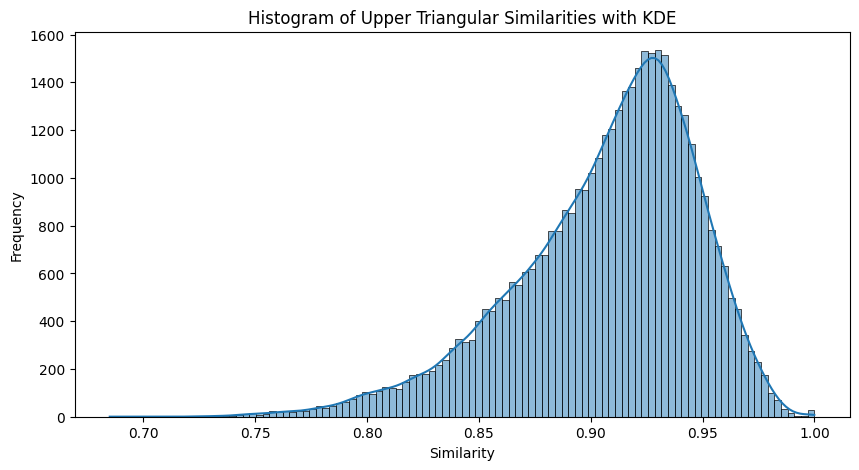

In [60]:
# Extract similarities
np.fill_diagonal(similarity_matrix, np.nan)
upper_tri_indices = np.triu_indices_from(similarity_matrix, k=1)
similarities = similarity_matrix[upper_tri_indices]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=True)
plt.title('Histogram of Upper Triangular Similarities with KDE')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

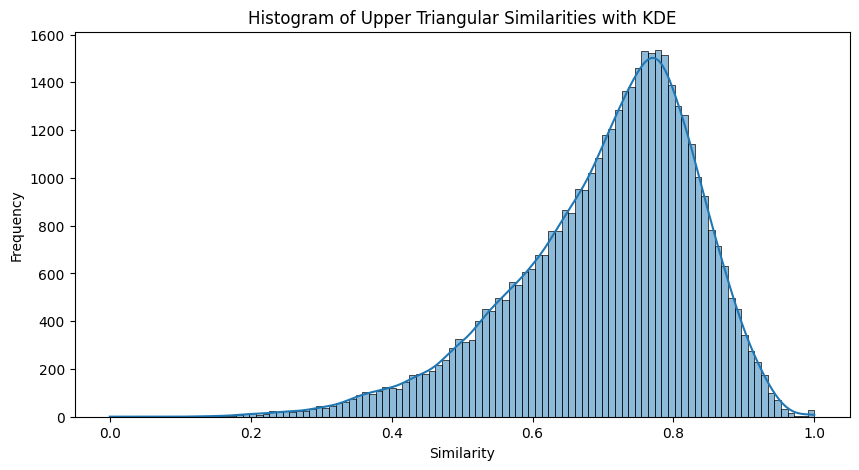

In [70]:
# Renormalize
similarity_matrix_normed = renormalize_similarities(similarity_matrix)

# Plot renormalizaiton

# Extract similarities
upper_tri_indices = np.triu_indices_from(similarity_matrix_normed, k=1)
similarities = similarity_matrix_normed[upper_tri_indices]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(similarities, kde=True)
plt.title('Histogram of Upper Triangular Similarities with KDE')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()

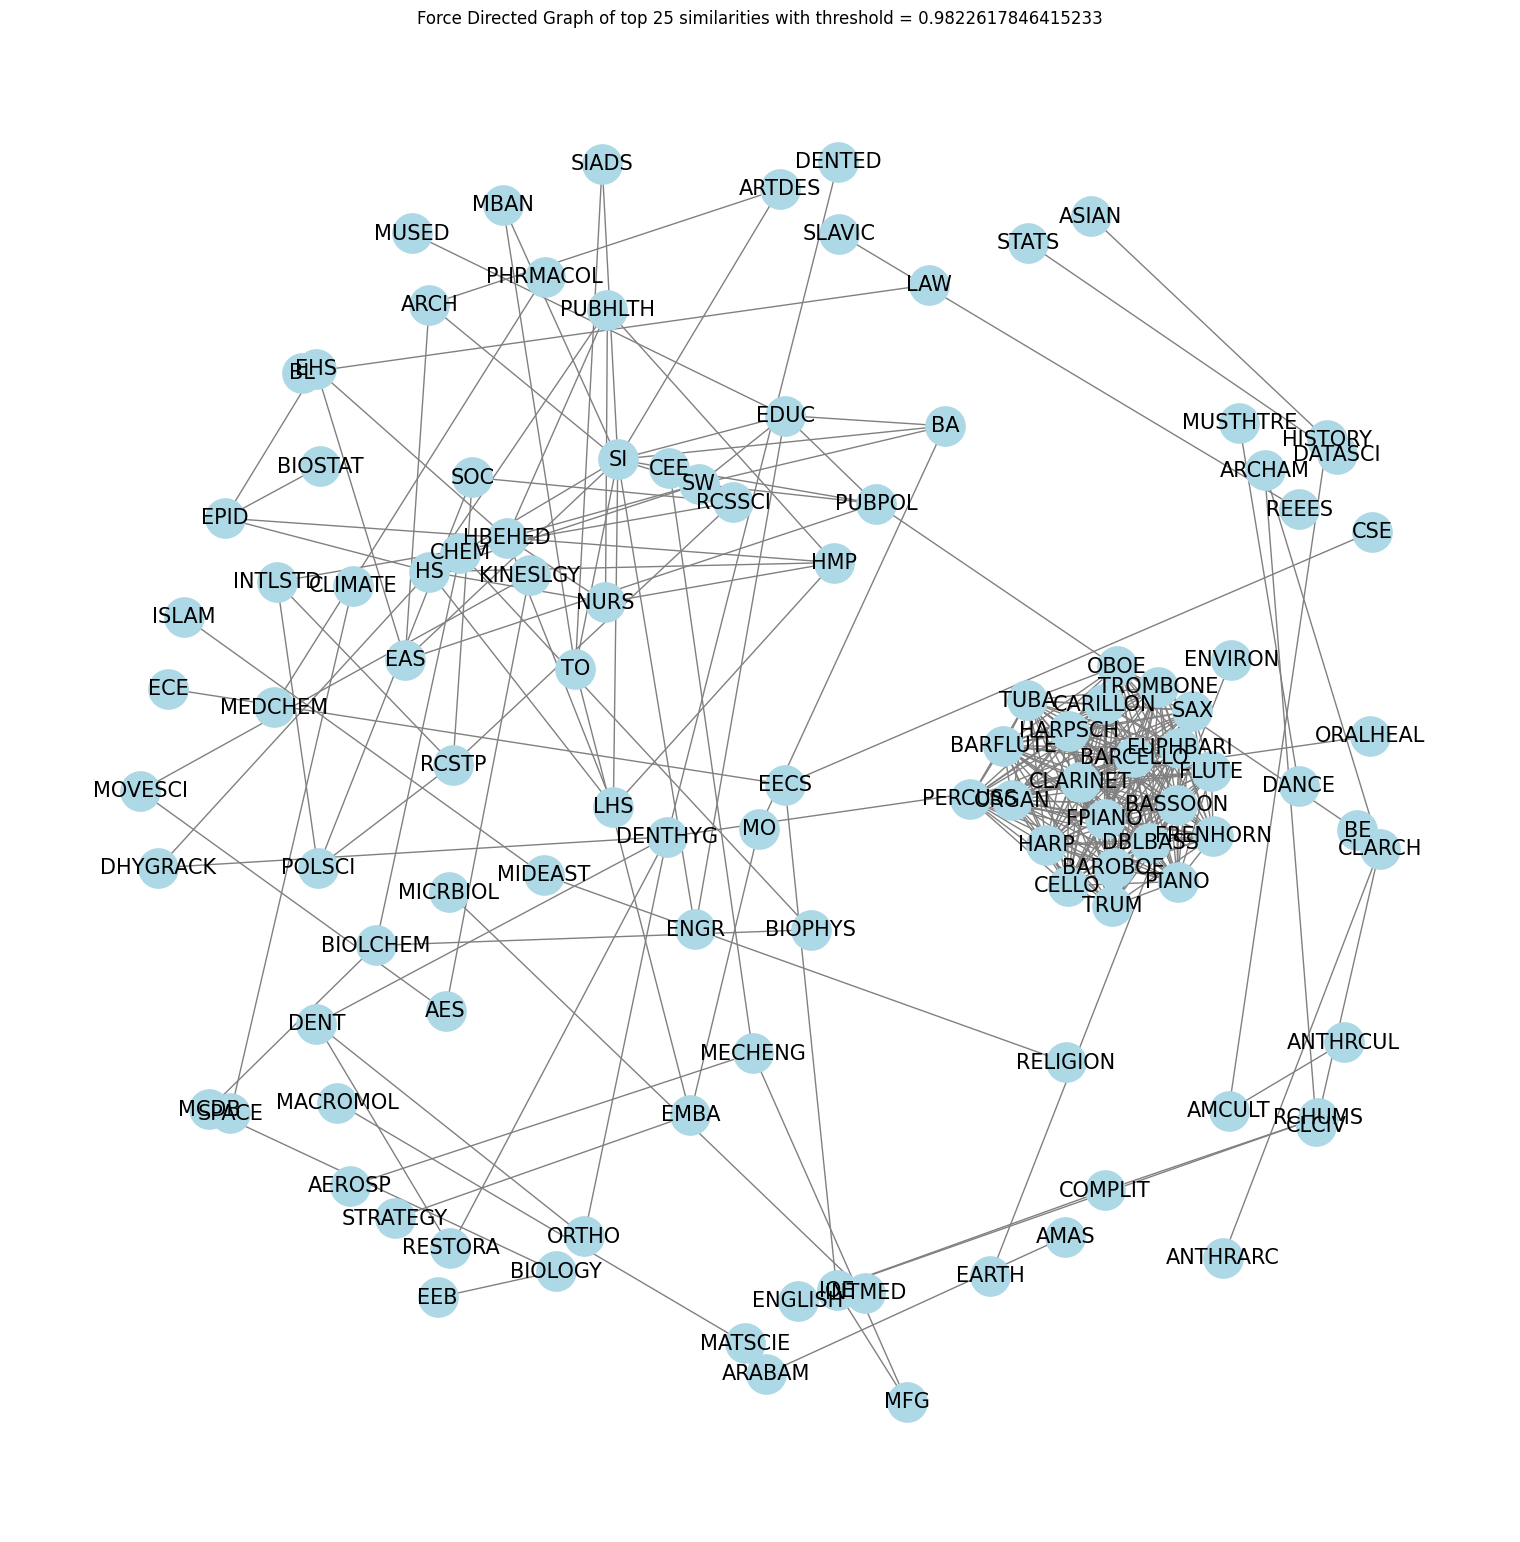

In [96]:
adjacency_matrix = similarity_matrix_normed

# Create a graph
G = nx.Graph()

threshold = get_threshold(similarity_matrix_normed, 30)

course_indices = set()
# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        if similarity_matrix[i][j] >= threshold:
            course_indices.add(i)
            course_indices.add(j)
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title(f"Force Directed Graph of top 25 similarities with threshold = {threshold}")
plt.show()

In [ ]:
stem = set(["AEROSP", "EECS", "MATH", "PHYSICS", "STATS", "ENGR", "ASTRO", "CEE", "MECHENG", "DATASCI", "BIOMEDE", "BIOPHYS", "SPACE", "CHEM", "BIOPHYS", "CMPLXSYS"])